## Use keras tuner to pefrom cnn model optimisation for tumor image detection

In [1]:
from google.colab import drive
drive.mount('/content/drive') # change this you your own path.

Mounted at /content/drive


In [3]:
# !pip install -q -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.7 MB/s eta 0:00:00


In [4]:
# import all dependencies
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from keras_tuner import RandomSearch

In [5]:
# build keras-tuner auto tuner 
def build_model(hp):
  # call the Sequential model builder
  model = tf.keras.models.Sequential()

  # add the input layer
  model.add(tf.keras.layers.Input(shape=(224, 224, 1))) # speify the unified image input as previous training

  # add first convlutional layer, pre-set all params, this layer does not contains changable params.
  model.add(tf.keras.layers.Conv2D(
      filters = 32,
      kernel_size = (5, 5),
      activation = 'relu',
      strides = (1, 1),
      padding = 'same'
  ))

  # add first pooling layer
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

  # to test the effect of dropout layer, didn't add the dropout in the first conv layer
  # use the loop to add additional layers to test
  for i in range(hp.Int('num_conv_layers', 2, 4)):
    model.add(tf.keras.layers.Conv2D(
        filters = hp.Int(f"filters_{str(i+2)}", min_value = 32, max_value = 128, step = 32),
        kernel_size = (3, 3),
        activation = 'relu',
        strides = (1, 1),
        padding = 'same'
    ))

    # add the Batch Normalisation layer after each conv2d layer
    model.add(tf.keras.layers.BatchNormalization())
    # add Maxpooling2D layer as well
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    # add dropout layers here to reduce potential overfitting
    model.add(tf.keras.layers.Dropout(0.2))

  # add the flatten layer
  model.add(tf.keras.layers.Flatten())
  # add the dense layers
  model.add(tf.keras.layers.Dense(128, activation = 'relu'))
  # add dropout layer again
  model.add(tf.keras.layers.Dropout(0.5))
  # add the output layer
  model.add(tf.keras.layers.Dense(4, activation='softmax'))

  # define the optimizer of learning rate scheduler as hyperparameter
  scheduled_learning_rate = hp.Choice("lr", [1e-3, 1e-4, 1e-5])
  model.compile(
      optimizer = tf.keras.optimizers.Adam(learning_rate=scheduled_learning_rate),
      loss = 'categorical_crossentropy',
      metrics = ['accuracy']
  )

  # Raise an error when the model is too large
  num_params = model.count_params()
  if num_params > 16000000:
      # When this error is raised, it skips the retries.
      raise kt.errors.FailedTrailError(f"Model is too complex to handle! It contains {num_params} params.")

  return model



In [6]:
tuner = RandomSearch(
    hypermodel = build_model,
    objective = 'val_accuracy',
    overwrite = True,
    max_trials = 15, 
    max_retries_per_trial = 3, # try at most 3 times
    max_consecutive_failed_trials = 3, # terminate all trial if failed 3 times in a role
    directory= '/content/drive/MyDrive/Colab_Notebooks/Brain_Tumor_MRI',
    project_name= 'JZ_keras-tuner_optimise_model'
)

## load the image data as before

In [7]:
# loading all image data:
img_size = (224, 224)  # set images to this size globally
batch_size = 32  # set batch size globally
seed = 168  # Random seed for consistency and ensure reproducibility
validation_split = 0.2  # 20% of the data will be used for validation

training_data = tf.keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Colab_Notebooks/Brain_Tumor_MRI/Training',
    validation_split=validation_split,
    subset='training',
    labels='inferred',
    color_mode = 'grayscale', 
    image_size= img_size,
    batch_size= batch_size,
    shuffle = True,
    label_mode='categorical',
    seed = seed
)

validation_data = tf.keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Colab_Notebooks/Brain_Tumor_MRI/Training',
    validation_split=validation_split,
    subset='validation',
    labels='inferred',
    color_mode = 'grayscale',
    image_size= img_size,
    batch_size= batch_size,
    shuffle = False,
    label_mode='categorical',
    seed = seed
)

testing_data = tf.keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Colab_Notebooks/Brain_Tumor_MRI/Testing',
    labels='inferred',
    color_mode = 'grayscale',
    image_size= img_size,
    batch_size= batch_size,
    shuffle = False,
    label_mode='categorical',
    seed = seed
)


Found 2870 files belonging to 4 classes.
Using 2296 files for training.
Found 2870 files belonging to 4 classes.
Using 574 files for validation.
Found 394 files belonging to 4 classes.


In [8]:
# check the class names
class_names = training_data.class_names
class_names

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [9]:
# Checking the loaded data before resizing and scaling:
for images, labels in training_data.take(1):  # Take one batch of data from the tf.data.Data _mapData object
    print(images.shape)  # get the data shape after loaded
    print(images[0].shape)  # get the single image data's shape --> which is converted in tensors
    print(labels.shape)  # Shape of the labels batch, 32 batch all with 4 classes

(32, 224, 224, 1)
(224, 224, 1)
(32, 4)


## Apply normalisation, augumentation and rescaling to data

In [10]:
# Define a normalization layer, as the pixels range (1 to 255) on color scale, normalise it between (0 and 1)
normalisation_layer = tf.keras.layers.Rescaling(1./255)

# Add data augumentation layer to the training_dataset for increase diversity and prevent overfitting.
# because we can see the dataset is realatively small. so need to apply augumentation to increase training.
data_augumentation_layer = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'), # can't vertically flip as pathology MRI contains anatomically significance position, vertical rotation would distort and lead to biases.
    tf.keras.layers.RandomRotation(0.2), # begin with small range rotation and zoom
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.CenterCrop(height=224, width=224)
    # No random contrast change as not suitable for the image
])

# Apply augumentation and rescale to the training_data first
training_data_augumented = training_data.map(lambda x, y: (data_augumentation_layer(x), y))
training_data_normalised = training_data_augumented.map(lambda x, y: (normalisation_layer(x), y))

# Apply normalization to val and testing data as well.
validation_data_normalised = validation_data.map(lambda x, y: (normalisation_layer(x), y))
testing_data_normalised = testing_data.map(lambda x, y: (normalisation_layer(x), y))

Image after augmentation and normalization (numpy array):
[[[0.0072287 ]
  [0.00729196]
  [0.00735522]
  ...
  [0.0114916 ]
  [0.00900283]
  [0.0084996 ]]

 [[0.00819991]
  [0.00850801]
  [0.0088161 ]
  ...
  [0.01144673]
  [0.00853055]
  [0.00784314]]

 [[0.01140764]
  [0.01144408]
  [0.01148053]
  ...
  [0.0114805 ]
  [0.0088161 ]
  [0.00784314]]

 ...

 [[0.01176471]
  [0.01141722]
  [0.01082338]
  ...
  [0.01904139]
  [0.0229225 ]
  [0.02997195]]

 [[0.01176471]
  [0.01152908]
  [0.01076621]
  ...
  [0.01478831]
  [0.01877381]
  [0.03326556]]

 [[0.01176471]
  [0.01165949]
  [0.01123621]
  ...
  [0.01305379]
  [0.0188582 ]
  [0.03760636]]]


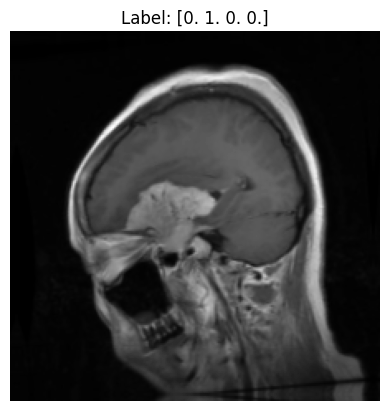

In [11]:
# checking
for images, labels in training_data_normalised.take(1):
    first_image = images[0]
    first_label = labels[0]
    print("Image after augmentation and normalization (numpy array):")
    print(first_image.numpy())
    plt.imshow(first_image.numpy().squeeze(), cmap='gray')
    plt.title(f'Label: {first_label.numpy()}')
    plt.axis('off')
    plt.show()
    break

In [12]:
# start the tuner RandomSearch:
try:
    tuner.search(
        training_data_normalised,
        validation_data = validation_data_normalised,
        epochs = 20 # run 20 epochs for each search.
    )

except kt.errors.FatalError as e:
    print(f"terminate search due to error: {e}")

Trial 15 Complete [00h 03m 34s]
val_accuracy: 0.7822299599647522

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 53m 10s


In [13]:
# get the first 3 best perfroming models:
best_3_models = tuner.get_best_models(num_models=3)

for mod in best_3_models:
  mod.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      12,845,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,893,412 (49.18 MB)

 Trainable params: 12,893,092 (49.18 MB)

 Non-trainable params: 320 (1.25 KB)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         802,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 851,012 (3.25 MB)

 Trainable params: 850,756 (3.25 MB)

 Non-trainable params: 256 (1.00 KB)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 96)        │          27,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 112, 112, 96)        │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 56, 56, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 96)          │          83,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 56, 56, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 28, 28, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 75264)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       9,633,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,746,820 (37.18 MB)

 Trainable params: 9,746,436 (37.18 MB)

 Non-trainable params: 384 (1.50 KB)

## So we can see that the best 3 model contains various layers and different params in total

In [14]:
# get the hyperparameters of the best 3 performing models:
best_3_hyperparameters = tuner.get_best_hyperparameters(num_trials=3)

for hp in best_3_hyperparameters:
  print(hp.values)

{'num_conv_layers': 2, 'filters_2': 32, 'filters_3': 128, 'lr': 0.001}
{'num_conv_layers': 3, 'filters_2': 32, 'filters_3': 64, 'lr': 0.001, 'filters_4': 32}
{'num_conv_layers': 2, 'filters_2': 96, 'filters_3': 96, 'lr': 1e-05, 'filters_4': 32}


In [16]:
# Iterate through all trials to get details of each trial's results
for trial in tuner.oracle.get_best_trials(num_trials=3):
    print(f"Trial: {trial.trial_id}, Accuracy: {trial.metrics.get_last_value('accuracy')}, Val Accuracy: {trial.metrics.get_last_value('val_accuracy')}")

Trial: 00, Accuracy: 0.3462543487548828, Val Accuracy: 1.0
Trial: 02, Accuracy: 0.532665491104126, Val Accuracy: 1.0
Trial: 03, Accuracy: 0.37979093194007874, Val Accuracy: 1.0


In [17]:
# Get all the completed trials and print their results
for trial in tuner.oracle.trials.values():
    print(f"Trial {trial.trial_id} completed")
    print(f"  Hyperparameters: {trial.hyperparameters.values}")
    print(f"  Final accuracy: {trial.metrics.get_last_value('accuracy')}")
    print(f"  Final validation accuracy: {trial.metrics.get_last_value('val_accuracy')}")
    print(f"  Final validation loss: {trial.metrics.get_last_value('val_loss')}")

Trial 00 completed
  Hyperparameters: {'num_conv_layers': 2, 'filters_2': 32, 'filters_3': 128, 'lr': 0.001}
  Final accuracy: 0.3462543487548828
  Final validation accuracy: 1.0
  Final validation loss: 5.5651133152423427e-05
Trial 01 completed
  Hyperparameters: {'num_conv_layers': 2, 'filters_2': 128, 'filters_3': 128, 'lr': 0.0001}
  Final accuracy: 0.5200348496437073
  Final validation accuracy: 0.9825783967971802
  Final validation loss: 0.11511994898319244
Trial 02 completed
  Hyperparameters: {'num_conv_layers': 3, 'filters_2': 32, 'filters_3': 64, 'lr': 0.001, 'filters_4': 32}
  Final accuracy: 0.532665491104126
  Final validation accuracy: 1.0
  Final validation loss: 0.08725212514400482
Trial 03 completed
  Hyperparameters: {'num_conv_layers': 2, 'filters_2': 96, 'filters_3': 96, 'lr': 1e-05, 'filters_4': 32}
  Final accuracy: 0.37979093194007874
  Final validation accuracy: 1.0
  Final validation loss: 0.5963221788406372
Trial 04 completed
  Hyperparameters: {'num_conv_laye

### After the tuner, However the accuracy is not good.

In [15]:
# evaluate the best 3 models performance on testing data:
for model in best_3_models:
  results = model.evaluate(testing_data_normalised)
  print(f"Model accuracy: {results[1]}, Model loss: {results[0]}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 486ms/step - accuracy: 0.1928 - loss: 13.5159
Model accuracy: 0.2588832378387451, Model loss: 13.565275192260742
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.0741 - loss: 5.4427
Model accuracy: 0.18020305037498474, Model loss: 5.942835807800293
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.0452 - loss: 1.6595
Model accuracy: 0.1878172606229782, Model loss: 1.753928542137146


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.19      0.19      0.19       100
meningioma_tumor       0.47      0.16      0.24       115
        no_tumor       0.15      0.02      0.03       105
 pituitary_tumor       0.26      0.85      0.40        74

        accuracy                           0.26       394
       macro avg       0.27      0.30      0.21       394
    weighted avg       0.28      0.26      0.20       394



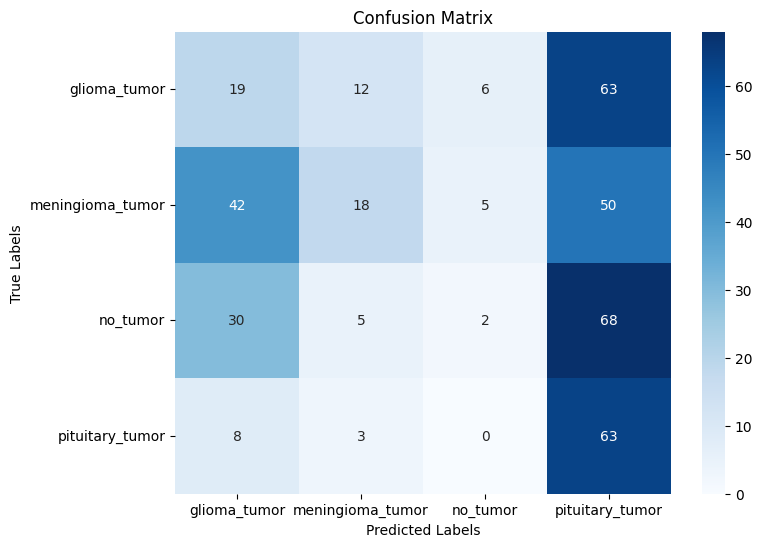

In [49]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
y_pred = []
y_true = []
class_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

best_model_1 = best_3_models[0]
for images, labels in testing_data_normalised:
    predictions = best_model_1.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    y_pred.extend(predicted_classes)
    y_true.extend(np.argmax(labels, axis=1))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))

# Classification Report
class_report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", class_report)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()

### Analysis from the classification report and the confusion matrix:

So from the report, we can see that even after the tuner random search to find the optimal params and model settings. The testing accuracy is still terrible, only around 26%. Also, from the report, we can see that among all testing, the meningioma_tumor achieves the highest classification score compare with other 3 classes. But still poor, which is about 47%. For pituitary_tumor, recall is 0.85, indicating that 85% of actual pituitary_tumor instances were correctly identified. However, no_tumor has a recall of 0.02 which meaning most no_tumor cases were missed.

to optimise the model further, I consider to run another trail of keras-tuner search, using the best performing model as the base. 


In [27]:
# Create a list to store the results
tuner_results = []

# Iterate over all the completed trials
for trial in tuner.oracle.trials.values():
    trial_data = {
        'Trial ID': trial.trial_id,
        'Learning Rate': trial.hyperparameters.values['lr'],
        'Number of Conv Layers': trial.hyperparameters.values['num_conv_layers'],
        'Filters': [trial.hyperparameters.values[f"filters_{str(i+2)}"] for i in range(trial.hyperparameters.values['num_conv_layers'])],
        'Final Accuracy': trial.metrics.get_last_value('accuracy'),
        'Final Validation Accuracy': trial.metrics.get_last_value('val_accuracy'),
        'Final Validation Loss': trial.metrics.get_last_value('val_loss')
    }
    tuner_results.append(trial_data)

# Convert the list of trial results to a DataFrame
df_results = pd.DataFrame(tuner_results)

# Save the DataFrame to a CSV file
df_results.to_csv('/content/drive/MyDrive/Colab_Notebooks/Brain_Tumor_MRI/tuning_results_valAccuracy_metric.csv', index=False, header = True)

## From the result we can see it's still performing poorly, let's try another keras-tuner optimisation trail. But this time we will use the best performing model as the model base. Then pass this model to the next keras tuner trail, focus on metrics = 'val_loss'.

In [22]:
# save the 1st best performing model:
best_model_val_accuracy = tuner.get_best_models(num_models=1)[0]

# save the weights of this model:
best_model_val_accuracy.save_weights('/content/drive/MyDrive/Colab_Notebooks/Brain_Tumor_MRI/best_model_val_accuracy_weights.weights.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [28]:
# save the model:
best_model_val_accuracy.save('/content/drive/MyDrive/Colab_Notebooks/Brain_Tumor_MRI/best_model_val_accuracy.h5')

In [29]:
# set up the second tuner trail:
def build_model_2(hp):
  # construct the model architecture again:
  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.Input(shape=(224, 224, 1)))

  model.add(tf.keras.layers.Conv2D(
      filters = 32,
      kernel_size = (5, 5),
      activation = 'relu',
      strides = (1, 1),
      padding = 'same'
  ))

  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

  # to test the effect of dropout layer, didn't add the dropout in the first conv layer
  # use the loop to add additional layers to test
  for i in range(hp.Int('num_conv_layers', 2, 4)):
    model.add(tf.keras.layers.Conv2D(
        filters = hp.Int(f"filters_{str(i+2)}", min_value = 32, max_value = 128, step = 32),
        kernel_size = (3, 3),
        activation = 'relu',
        strides = (1, 1),
        padding = 'same'
    ))

    # add the Batch Normalisation layer after each conv2d layer
    model.add(tf.keras.layers.BatchNormalization())
    # add Maxpooling2D layer as well
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    # add dropout layers here to reduce potential overfitting
    model.add(tf.keras.layers.Dropout(0.2))

  # add the flatten layer
  model.add(tf.keras.layers.Flatten())
  # add the dense layers
  model.add(tf.keras.layers.Dense(128, activation = 'relu'))
  # add dropout layer again
  model.add(tf.keras.layers.Dropout(0.5))
  # add the output layer
  model.add(tf.keras.layers.Dense(4, activation='softmax'))

  # load the previous best performing model's weight here
  try:
    model.load_weights('/content/drive/MyDrive/Colab_Notebooks/Brain_Tumor_MRI/best_model_val_accuracy.h5',
                       by_name = True, skip_mismatch = True)
    print('successfully loaded the weights.')
  except Exception as e:
    print(f"Error when loading weights: {e}")

  # define the optimizer of learning rate scheduler as hyperparameter
  scheduled_learning_rate = hp.Choice("lr", [1e-3, 1e-4, 1e-5])
  # re-compile the model for tuner
  model.compile(
      optimizer = tf.keras.optimizers.Adam(learning_rate=scheduled_learning_rate),
      loss = 'categorical_crossentropy',
      metrics = ['accuracy']
  )

  # Raise an error when the model is too large
  num_params = model.count_params()
  if num_params > 16000000:
      # When this error is raised, it skips the retries.
      raise kt.errors.FailedTrailError(f"Model is too complex to handle! It contains {num_params} params.")

  return model

In [30]:
tuner_2 = RandomSearch(
    hypermodel = build_model_2,
    objective = 'val_loss',
    overwrite = True,
    max_trials = 20, # run 20 times
    max_retries_per_trial = 3, # try at most 3 times
    max_consecutive_failed_trials = 3, # terminate all trial if failed 3 times in a role
    directory= '/content/drive/MyDrive/Colab_Notebooks/Brain_Tumor_MRI',
    project_name= 'JZ_keras-tuner_optimise_model_2'
)

successfully loaded the weights.


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:262: UserWarning: Skipping loading top-level weights for model due to mismatch in number of weights. Model expects 18 top-level weight(s). Received 0 saved top-level weight(s)
  legacy_h5_format.load_weights_from_hdf5_group_by_name(


Image after augmentation and normalization (numpy array):
[[[0.01926124]
  [0.02032584]
  [0.01909117]
  ...
  [0.00784314]
  [0.00790663]
  [0.00834232]]

 [[0.01618109]
  [0.01945372]
  [0.0197069 ]
  ...
  [0.00784314]
  [0.00784314]
  [0.0079452 ]]

 [[0.01849716]
  [0.02247385]
  [0.02237545]
  ...
  [0.00784314]
  [0.00784314]
  [0.00784314]]

 ...

 [[0.2482062 ]
  [0.2416173 ]
  [0.22879793]
  ...
  [0.01211751]
  [0.01219388]
  [0.01176471]]

 [[0.24928372]
  [0.24792422]
  [0.23383728]
  ...
  [0.01241233]
  [0.0123499 ]
  [0.01199495]]

 [[0.24705239]
  [0.25363457]
  [0.24082443]
  ...
  [0.01390579]
  [0.01349233]
  [0.01311042]]]


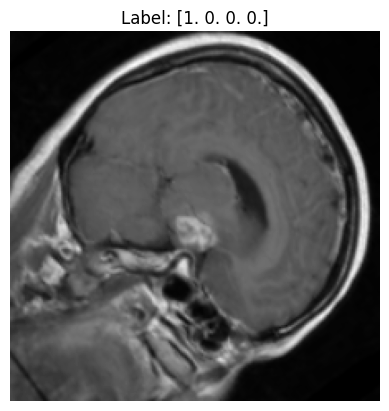

In [37]:
# checking again:
for images, labels in training_data_normalised.take(2):
    first_image = images[1]
    first_label = labels[1]
    print("Image after augmentation and normalization (numpy array):")
    print(first_image.numpy())
    plt.imshow(first_image.numpy().squeeze(), cmap='gray')
    plt.title(f'Label: {first_label.numpy()}')
    plt.axis('off')
    plt.show()
    break

In [38]:
# start the tuner RandomSearch trail 2:
try:
    tuner_2.search(
        training_data_normalised,
        validation_data = validation_data_normalised,
        epochs = 20 # run 20 epochs for each search.
    )

except kt.errors.FatalError as e:
    print(f"terminate search due to error: {e}")

Trial 20 Complete [00h 03m 33s]
val_loss: 0.6197004914283752

Best val_loss So Far: 0.0
Total elapsed time: 01h 10m 14s


In [39]:
# get the first 3 best perfroming models:
best_3_models_2 = tuner_2.get_best_models(num_models=3)

for mod in best_3_models_2:
  mod.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:262: UserWarning: Skipping loading top-level weights for model due to mismatch in number of weights. Model expects 18 top-level weight(s). Received 0 saved top-level weight(s)
  legacy_h5_format.load_weights_from_hdf5_group_by_name(


successfully loaded the weights.


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


successfully loaded the weights.


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:262: UserWarning: Skipping loading weights for layer #2 (named conv2d_1) due to mismatch in shape for weight sequential/conv2d_1/kernel. Weight expects shape (3, 3, 32, 128). Received saved weight with shape (3, 3, 32, 32)
  legacy_h5_format.load_weights_from_hdf5_group_by_name(
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:262: UserWarning: Skipping loading weights for layer #2 (named conv2d_1) due to mismatch in shape for weight sequential/conv2d_1/bias. Weight expects shape (128,). Received saved weight with shape (32,)
  legacy_h5_format.load_weights_from_hdf5_group_by_name(
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:262: UserWarning: Skipping loading weights for layer #3 (named batch_normalization) due to mismatch in shape for weight sequential/batch_normalization/gamma. Weight expects shape (128,). Received saved weight with shape (32,)
  legacy_h5_format.lo

successfully loaded the weights.


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      12,845,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,893,412 (49.18 MB)

 Trainable params: 12,893,092 (49.18 MB)

 Non-trainable params: 320 (1.25 KB)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      12,845,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,893,412 (49.18 MB)

 Trainable params: 12,893,092 (49.18 MB)

 Non-trainable params: 320 (1.25 KB)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 128)       │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 96)          │         110,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 56, 56, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 28, 28, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,811,300 (6.91 MB)

 Trainable params: 1,810,724 (6.91 MB)

 Non-trainable params: 576 (2.25 KB)

In [41]:
# get the hyperparameters of the best 3 performing models:
best_3_hyperparameters_2 = tuner_2.get_best_hyperparameters(num_trials=3)

for hp in best_3_hyperparameters_2:
  print(hp.values)

{'num_conv_layers': 2, 'filters_2': 32, 'filters_3': 128, 'lr': 0.0001, 'filters_4': 32, 'filters_5': 64}
{'num_conv_layers': 2, 'filters_2': 32, 'filters_3': 128, 'lr': 0.0001, 'filters_4': 96, 'filters_5': 64}
{'num_conv_layers': 3, 'filters_2': 128, 'filters_3': 96, 'lr': 0.001, 'filters_4': 64}


In [42]:
# Iterate through all trials to get details of each trial's results
for trial in tuner_2.oracle.get_best_trials(num_trials=3):
    print(f"Trial: {trial.trial_id}, Accuracy: {trial.metrics.get_last_value('accuracy')}, Val Accuracy: {trial.metrics.get_last_value('val_accuracy')}")

Trial: 06, Accuracy: 0.34581881761550903, Val Accuracy: 1.0
Trial: 16, Accuracy: 0.3484320640563965, Val Accuracy: 1.0
Trial: 02, Accuracy: 0.4451219439506531, Val Accuracy: 1.0


In [43]:
# Get all the completed trials and print their results
for trial in tuner_2.oracle.trials.values():
    print(f"Trial {trial.trial_id} completed")
    print(f"  Hyperparameters: {trial.hyperparameters.values}")
    print(f"  Final accuracy: {trial.metrics.get_last_value('accuracy')}")
    print(f"  Final validation accuracy: {trial.metrics.get_last_value('val_accuracy')}")
    print(f"  Final validation loss: {trial.metrics.get_last_value('val_loss')}")

Trial 00 completed
  Hyperparameters: {'num_conv_layers': 2, 'filters_2': 64, 'filters_3': 32, 'lr': 1e-05}
  Final accuracy: 0.5744773745536804
  Final validation accuracy: 0.8083623647689819
  Final validation loss: 0.7153727412223816
Trial 01 completed
  Hyperparameters: {'num_conv_layers': 3, 'filters_2': 32, 'filters_3': 96, 'lr': 0.0001, 'filters_4': 32}
  Final accuracy: 0.5709930062294006
  Final validation accuracy: 0.9459930062294006
  Final validation loss: 0.2101656198501587
Trial 02 completed
  Hyperparameters: {'num_conv_layers': 3, 'filters_2': 128, 'filters_3': 96, 'lr': 0.001, 'filters_4': 64}
  Final accuracy: 0.4451219439506531
  Final validation accuracy: 1.0
  Final validation loss: 6.271986308092892e-08
Trial 03 completed
  Hyperparameters: {'num_conv_layers': 4, 'filters_2': 128, 'filters_3': 64, 'lr': 0.001, 'filters_4': 96, 'filters_5': 32}
  Final accuracy: 0.7582752704620361
  Final validation accuracy: 1.0
  Final validation loss: 0.0009336847579106688
Trial

In [44]:
# evaluate the best 3 models performance on testing data:
for model in best_3_models_2:
  results = model.evaluate(testing_data_normalised)
  print(f"Model accuracy: {results[1]}, Model loss: {results[0]}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.0856 - loss: 32.0556
Model accuracy: 0.2157360464334488, Model loss: 30.434953689575195
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.0712 - loss: 37.8686
Model accuracy: 0.21065989136695862, Model loss: 33.97211456298828
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.0452 - loss: 15.1364
Model accuracy: 0.1878172606229782, Model loss: 13.207967758178711


In [45]:
# Create a list to store the results
tuner_results_2 = []

# Iterate over all the completed trials
for trial in tuner_2.oracle.trials.values():
    trial_data = {
        'Trial ID': trial.trial_id,
        'Learning Rate': trial.hyperparameters.values['lr'],
        'Number of Conv Layers': trial.hyperparameters.values['num_conv_layers'],
        'Filters': [trial.hyperparameters.values[f"filters_{str(i+2)}"] for i in range(trial.hyperparameters.values['num_conv_layers'])],
        'Final Accuracy': trial.metrics.get_last_value('accuracy'),
        'Final Validation Accuracy': trial.metrics.get_last_value('val_accuracy'),
        'Final Validation Loss': trial.metrics.get_last_value('val_loss')
    }
    tuner_results_2.append(trial_data)

# Convert the list of trial results to a DataFrame
df_results_2 = pd.DataFrame(tuner_results_2)

# Save the DataFrame to a CSV file
df_results_2.to_csv('/content/drive/MyDrive/Colab_Notebooks/Brain_Tumor_MRI/tuning_results_valLossy_metric.csv', index=False, header = True)

## Didn't save this model and its weights, as this performance is worse than the previous trail.

## Analysis of the result:

It is odd to see that after this trail of keras tuner, the model's performance even dropped. Therefore I did not save neither the weight nor the model.h5 files. This indicates several potential issue:

Firstly, the image for class is not sufficient, besides, as a multiclass classification model. especially the lack of normal brain MRI images compared with other 3 classes. This also caused the poor evaluation accuracy on this class.
Besides, my cnn construction might not be deep and large enough for this task. However, this is the drawbacks of considering balance between the computation resources and the model accuracy. Complex model requires longer and more data to train.
From all the tunning and optimising tries. I noticed one issue that might also cause the unideal model performance. The images are resized to unified size before passing into models, but the image varies in edges, which trimming of the excessive black edges might help with the model to better learn the pattern. The attempt of performing data augumentation did not work well. When I visualise the fliped and randomly rotated images. Many of them were distored in some extent. which might also interfere with the correct learning of the model.

To summarise. for the project. We will utilise other groupmember's model with higher test accuracy.

